Neural network for importance sampling supplemented variational inference.

## Theory

Let $\theta \in \mathbb{R}^{N_d}$ the parameters, and $p(\theta)$ the PDF of the posterior over the parameter-space. Let $q(\theta; z)$ the inference distribution, with parameter $z$ to be trained. Let
\begin{equation}
  \hat{q}(\theta; z, w) := \omega (\theta; w) q(\theta, z),
\end{equation}
where $\omega (\theta; w)$, mapping to $\mathbb{R}$, is the weights of the importance sampling, with parameter $w$ to be trained.

The loss-function is
\begin{align}
  \mathcal{L} (z, w)
    & := \textrm{KL}(\hat{q} \| p) \\
    & = \int \hat{q} (\theta)
          \left[ \ln \hat{q} (\theta; z, w) - \ln p (\theta) \right]
        d \theta \\
    & = \int q(\theta) \omega (\theta; w)
          \left[ \ln \omega (\theta; w) + \ln q (\theta; z)
                 - \ln p (\theta) \right]
        d \theta \\
    & = \mathbb{E}_{\theta_s \sim q(z)}
          \left\{ \omega (\theta_s; w)
            \left[ \ln \omega (\theta_s; w) + \ln q (\theta_s; z)
                   - \ln p (\theta_s) \right] \right\},
\end{align}
where $s = 1, \ldots, N_s$. Further, for $\theta \in \{\theta_1, \ldots, \theta_{N_s}\} \sim q(z)$, let
\begin{equation}
  \omega(\theta; w) := \textrm{softmax} \left( \zeta (\theta; w) \right) * N_s,
\end{equation}
the normalization of $\hat{q}(\theta; z, w)$ can always be ensured:
\begin{align}
  1 & = \int \hat{q}(\theta; z, w) d\theta \\
    & = \mathbb{E}_{\theta_s \sim q(z)} \left[ \omega (\theta; w) \right] \\
    & = N_s * \mathbb{E}_{\theta_s \sim q(z)}
                \left[ \textrm{softmax} \left( \zeta (\theta; w) \right) \right] \\
    & = N_s * \frac{1}{N_s}
        \sum_s \textrm{softmax}_s \left( \zeta (\theta; w) \right) \\
    & = N_s \frac{1}{N_s} \times 1.
\end{align}

This methods extends the representability of pure variational inference by adding a weight-function. This weight-function can be implemented by a neural network by the utility of its universality.

We do not prefer a large variance of the weights, thus a penalty on this variance in the loss is called for. Thus
\begin{align}
  \mathcal{L}(z, w)
    & \to \mathcal{L}(z, w; \lambda) \\
    & = \mathbb{E}_{\theta_s \sim q(z)}
          \left\{ \omega (\theta_s; w)
            \left[ \ln \omega (\theta_s; w) + \ln q (\theta_s; z)
                   - \ln p (\theta_s) \right]
            + \lambda \omega^2(\theta_s; w) \right\},
\end{align}
where $\lambda$ is a hyper-parameter.

The machine will automatically minimizes this loss by tuning the trainable parameters $(z, w)$, and then find a "harmonic" way of combining the $\omega$ and $q$, so as to represent the target $p(\theta)$.

## Implementation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.distributions as tfd
from collections import namedtuple
from uba.utils.math import softplus

In [2]:
LossInfo = namedtuple('LossInfo',
    ('loc, scale, inference_dist, samples, sample_logits,'
      'weights, log_weights, log_ps, log_qs, kl_divergence,'
      'weight_penalty, loss'))

def make_loss(n_dims, log_p, logits, logits_scale=1.0, n_samples=10):
  """
  Args:
    n_dims: Positive integer.
    log_p: Callable from tensor of the shape `[n_dims]` to scalar.
    logits: Callable from tensor of the shape `[n_samples, n_dims]`
      to tensor of the shape `[n_samples]`.
    logits_scale: Positive float.
  Returns:
    An instance of `LossInfo`.
  """
  with tf.name_scope('Loss'):
    with tf.name_scope('InferenceDistribution'):
      loc = tf.get_variable('loc', [n_dims], 'float32')
      scale = tf.get_variable('scale', [n_dims], 'float32')
      inference_dist = tfd.Independent(
          tfd.NormalWithSoftplusScale(loc, scale))
    with tf.name_scope('Samples'):
      # shape `[n_samples, n_dims]`
      samples = inference_dist.sample(n_samples)
    with tf.name_scope('Logits'):
      # shape: `[n_samples]`
      sample_logits = logits(samples)
    with tf.name_scope('KLDivergence'):
      # shape: `[n_samples]`
      weights = tf.nn.softmax(sample_logits) * n_samples
      # shape: `[n_samples]`
      log_weights = tf.log(weights)
      # The batch-supplement may not ensured in `log_p`,
      # so we employ `tf.map_fn` for vectorization
      # shape: `[n_samples]`
      log_ps = tf.map_fn(log_p, samples)
      # Notice `tfd.Distribution.log_prob()` is batch-supplemented,
      # shape: `[n_samples]`
      log_qs = inference_dist.log_prob(samples)
      # shape: `[]`
      kl_divergence = tf.reduce_mean(
        weights * (log_weights + log_qs - log_ps),
        axis=0)
      # shape: `[]`
      weight_penalty = logits_scale \
        * tf.reduce_mean(tf.square(weights - 1), axis=0)
      # shape: `[]`
      # loss = kl_divergence + weight_penalty
      loss = kl_divergence * (1 + weight_penalty)
      return LossInfo(loc, scale, inference_dist, samples, sample_logits,
                      weights, log_weights, log_ps, log_qs, kl_divergence,
                      weight_penalty, loss)

## Experiments

### High-dimensional Gaussian distribution

Set up graph

In [3]:
tf.reset_default_graph()

The target is the PDF of distribution
$\mathcal{N} \left(0, \textrm{softplus}(10)\right)$
on $\mathbb{R}^{N_d}$.

In [4]:
n_dims = 10000
target_dist = tfd.Independent(
    tfd.NormalWithSoftplusScale(loc=tf.zeros(n_dims),
                                scale=10*tf.ones(n_dims)))

In [5]:
def logits(samples, n_hiddens=5):
  """The `logits` argument of `make_loss()`."""
  with tf.name_scope('LogitsNeuralNetwork'):
    # shape: `[n_samples, n_hiddens]`
    hiddens = tf.layers.dense(samples, n_hiddens,
                              activation=tf.nn.leaky_relu)
    # shape: `[n_samples, 1]`
    outputs = tf.layers.dense(hiddens, 1)
    # shape: `[n_samples]`
    return tf.squeeze(outputs, axis=1)

In [6]:
loss_info = make_loss(n_dims, target_dist.log_prob, logits)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss_info.loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Training

In [7]:
print('Loss (before):', sess.run(loss_info.loss))

n_iters = 20000
for step in range(1, n_iters+1):
  sess.run(train_op)
  
  # The value of loss can sometimes temporally be `NaN`, and in
  # the next `sess.run()` becomes non-`NaN` (strange!). So, we
  # employ the following strategy:
  loss_val = sess.run(loss_info.loss)
  n_trials = 0
  while np.isnan(loss_val) and n_trials < 10:
    loss_val = sess.run(loss_info.loss)
    n_trials += 1
    if n_trials == 9:
      print(sess.run([loss_info.log_weights, loss_info.log_ps,
                      loss_info.log_qs, loss_info.kl_divergence,
                      loss_info.weight_penalty]))
  if n_trials == 9:
    print('Always `NaN`, finally stopped at step {}.'.format(step))
    break
    
  if step % 100 == 0:
    print('{0}  |  {1}'.format(step, sess.run(loss_info.loss)))

print('Loss (after):', sess.run(loss_info.loss))
print('Weight penalty (after):', sess.run(loss_info.weight_penalty))

Loss (before): 51517.3
100  |  24384.0
200  |  23495.37890625
300  |  22766.560546875
400  |  22557.716796875
500  |  24041.099609375
600  |  22584.802734375
700  |  22903.51171875
800  |  22531.5234375
900  |  22661.9609375
1000  |  22551.880859375
1100  |  22557.8671875
1200  |  22270.0390625
1300  |  21978.43359375
1400  |  21919.84765625
1500  |  22072.546875
1600  |  21782.423828125
1700  |  21661.904296875
1800  |  21605.8984375
1900  |  21894.2265625
2000  |  21518.271484375
2100  |  21500.037109375
2200  |  21485.48046875
2300  |  21630.26953125
2400  |  21362.615234375
2500  |  21342.474609375
2600  |  21338.638671875
2700  |  21141.94921875
2800  |  21139.34765625
2900  |  21098.208984375
3000  |  20956.23828125
3100  |  20914.453125
3200  |  20835.708984375
3300  |  20796.83203125
3400  |  20684.0234375
3500  |  20609.681640625
3600  |  20492.130859375
3700  |  20448.6796875
3800  |  20375.80859375
3900  |  20305.056640625
4000  |  20236.634765625
4100  |  20118.736328125
42

Visualize the trained results

In [8]:
samples = []
log_weights = []
for i in range(100):
  sample_vals, log_weight_vals = sess.run(
      [loss_info.samples, loss_info.log_weights])
  samples += [_ for _ in sample_vals]
  log_weights += [_ for _ in log_weight_vals]
samples = np.array(samples)
log_weights = np.array(log_weights)
print(samples.shape)
print(log_weights.shape)

(1000, 10000)
(1000,)


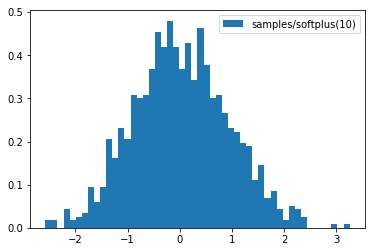

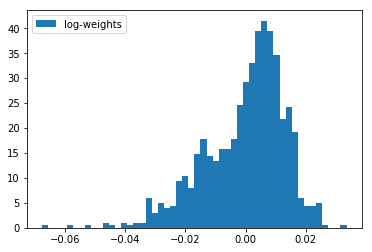

In [9]:
plt.hist(samples[:,0]/softplus(10), bins=50, density=True,
         label='samples/softplus(10)')
plt.legend()
plt.show()

plt.hist(log_weights, bins=50, density=True,
         label='log-weights')
plt.legend()
plt.show()

* Conclusion: so far so good.